In [59]:
import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import xarray as xr
import glob as glob
import os as os
import sys as sys

# get some stuff set up.

omega       = ['VVEL_P0_L100_GRLL0','OMEGA']
vertv       = ['DZDT_P0_L100_GRLL0','W']

_w_threshold = 5.0
_Rgas       = 287.04
_gravity    = 9.806

sw_corner = (27.776199263795622, -97.43436259615146)
ne_corner = (38.36255932569569, -81.65435850459758)

In [60]:
def fv3_extract_variables_over_region(file, sw_corner=None, ne_corner=None, writeout=True, prefix=None):
    
    print(f'FV3_Extract_Variables_Over_Region input file: {file}','\n')
    
    ds_all = xr.open_dataset(file)
        
    ds = xr.Dataset({
                       omega[1]: xr.DataArray(data = ds_all.__getitem__(omega[0])),                                       
                       vertv[1]: xr.DataArray(data = ds_all.__getitem__(vertv[0])),   
                    })
    
    ds = ds.rename_dims({'xgrid_0':'nx', 'ygrid_0': 'ny', 'lv_ISBL0': 'nz'})
    ds = ds.rename_vars({'lv_ISBL0':'levels', 'gridlat_0': 'lats', 'gridlon_0': 'lons'})
    ds = ds.sortby('nz', ascending=False)
    
    # extract region
    if (sw_corner and len(sw_corner) > 1) and (ne_corner and len(ne_corner) > 1):
        lat_min = min(sw_corner[0], ne_corner[0])
        lat_max = max(sw_corner[0], ne_corner[0])
        lon_min = min(sw_corner[1], ne_corner[1])
        lon_max = max(sw_corner[1], ne_corner[1])
        print(f'Creating a sub-region of DataArray: {lat_min:.2f}, {lon_min:.2f}, {lat_max:.2f}, {lon_max:5.2f}','\n')

        ds = ds.where( (lat_min < ds.lats) & (ds.lats < lat_max)
                     & (lon_min+360. < ds.lons) & (ds.lons < lon_max+360.), drop=True)
        
    if writeout:
        dir, base = os.path.split(file)
        if ((sw_corner and len(sw_corner) > 1) and (ne_corner and len(ne_corner) > 1)):
            if prefix == None: 
                outfilename = os.path.join(dir, 'region%s' % base[4:])
        else:
            if prefix == None:  
                outfilename = os.path.join(dir, 'full%s' % base[4:])
                
        ds.to_netcdf(outfilename)
        print(f'Wrote out file: {outfilename}','\n')
            
    return ds
    

In [61]:
fv3_dir   = '/Users/Louis.Wicker/04May2021_RRFS/mem1'
fv3_files = sorted(glob.glob(fv3_dir+'/rrfs.*.nc4'))
df_list = []
#for file in arw_files:
ds = fv3_extract_variables_over_region(fv3_files[0], sw_corner = sw_corner, ne_corner = ne_corner, writeout=True, prefix=None)
#ds = fv3_extract_variables_over_region(fv3_files[0], writeout=True, prefix=None)
print(f'Successfully created dataframe for file:  {fv3_files[0]}\n')

ds


FV3_Extract_Variables_Over_Region input file: /Users/Louis.Wicker/04May2021_RRFS/mem1/rrfs.t00z.mem01.naf018.nc4 

Creating a sub-region of DataArray: 27.78, -97.43, 38.36, -81.65 

Wrote out file: /Users/Louis.Wicker/04May2021_RRFS/mem1/region.t00z.mem01.naf018.nc4 

Successfully created dataframe for file:  /Users/Louis.Wicker/04May2021_RRFS/mem1/rrfs.t00z.mem01.naf018.nc4



<xarray.Dataset>
Dimensions:  (nx: 641, ny: 556, nz: 45)
Coordinates:
    levels   (nz) float32 1e+05 9.75e+04 9.5e+04 9.25e+04 ... 700.0 500.0 200.0
    lats     (ny, nx) float32 28.15 28.15 28.14 28.14 ... 36.73 36.72 36.71 36.7
    lons     (ny, nx) float32 260.4 260.4 260.4 260.5 ... 283.0 283.0 283.0
Dimensions without coordinates: nx, ny, nz
Data variables:
    OMEGA    (nz, ny, nx) float32 nan nan nan nan nan ... nan nan nan nan nan
    W        (nz, ny, nx) float32 nan nan nan nan nan ... nan nan nan nan nan

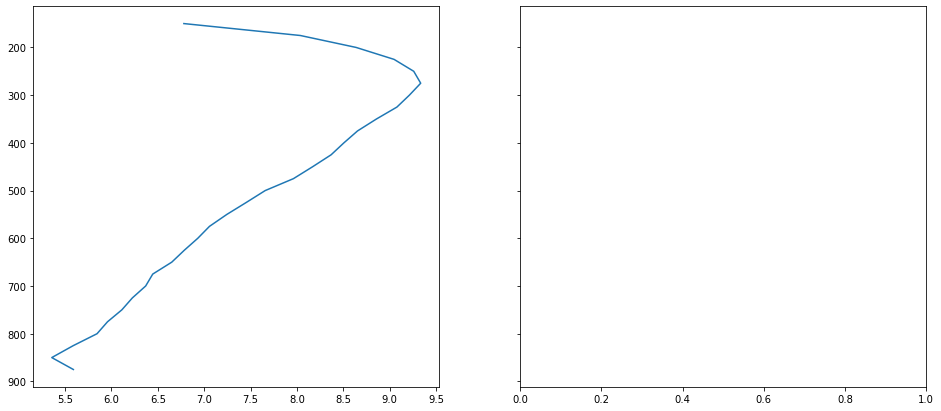

In [62]:
figsize = (16,7)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize = figsize)

dsW = ds.where( (ds.W > _w_threshold))

#dsW.plot.scatter(x="W", y="levels", ax=ax1)

dsWmean = dsW.mean(dim=("ny","nx"), skipna=True, keep_attrs=True)
ax1.plot(dsWmean.W, dsWmean.levels/100.)
ax1.invert_yaxis()
    

In [306]:
plt.show()